In [87]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# Bosch Production Line Performance

The plan is as follows:

1. Try to read in the data to pandas (or scipy sparse matrix??)  
2. Get std and mean for each feature
3. Calculate thresholds
4. Determine number of outliers in each sample

Intial look at .csv file (type `more train_numeric.csv` in Windows cmd) shows many features as follows: Id, L0_S0_F0, L0_S0_F2, L0_S0_F4, ... , 

where each part has a unique Id and L0 = 'line zero', S0 = 'station zero', F4 = 'feature number 4'.

The fact that F (feature number) skips numbers is due to the date features in `train_date.csv` which has timestamps representing when the features between it and the last time stamp were taken.  Finally, the categorical data in `train_categorical.csv` are taken less often than the numerical data. 

While browsing through the first lines of the .csv files, I noticed the NaNs seem to be grouped together in strings. This probably means that a given item does not need to use those stations on the line.

In [77]:
class BatchProcess():
    
    def __init__(self, file, batch_size):
        
        self.file = file
        self.num_rows = sum(1 for line in open(file))
        print('File length =', self.num_rows)
        
        self.batch_size = int(batch_size)
        self.num_batch = int(np.ceil(self.num_rows / self.batch_size))
    
    def df_make(self, skip = 1):
        ''' Build dataframe by iterating over chunks. Option to skip chunks and
            therefore read in less data. '''
        
        df = pd.DataFrame()
        reader = pd.read_csv(self.file, chunksize=self.batch_size,
                             dtype=np.float16)
        
        self.df = pd.concat([chunk for i, chunk in enumerate(reader) if i % skip == 0])
        
        return df
    
#     def df_apply_func(self, skip = 1, func=''):
#         ''' Build a dataframe  '''
        
#         if not func:
#             print('Select functions to compute:')
#             print('{"mean", "std", ""}')
        
#         reader = pd.read_csv(self.file, chunksize=self.batch_size,
#                              dtype=np.float16)
#         df_gen = (chunk.apply() for i, chunk in enumerate(reader) if i % skip == 0)
        
#         return pd.concat(df_gen)

    
#     def batch_process(type = ''):
#         '''  '''
        
    

In [75]:
input_path = '../input/'
train_numeric = BatchProcess(input_path+'train_numeric.csv', 100000)

File length = 1183748


In [76]:
%time df = train_numeric.df_make(skip=10, return=True)

AttributeError: 'BatchProcess' object has no attribute 'make_dataframe'

In [ ]:
print(np.round(len(df)/1183748 * 100, 3), '% of data')

### Loading entire numerical dataset

In [78]:
def df_load(file, batch_size, skip = 1):
    ''' Build dataframe by iterating over chunks. Option to skip chunks and
        therefore read in less data. '''

    reader = pd.read_csv(file, chunksize=batch_size,
                         dtype=np.float16)

    df = pd.concat((chunk for i, chunk in enumerate(reader) if i % skip == 0))

    return df

In [79]:
%%time
input_path = '../input/'
df_num = df_load(input_path+'train_numeric.csv',
                 batch_size=100000)

Wall time: 2min 42s


In [90]:
NaN_sum = df_num.isnull().sum()
print('NaNs = {:.2f}%'.format(NaN_sum.sum() / (df_num.shape[0] * df_num.shape[1]) * 100))

NaNs = 80.92%


About 80% of the dataset is NaN. The variable `NaN_sum` contains the number of NaN entries per column, below we see the distribution.

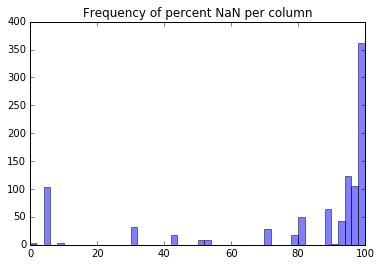

In [121]:
plt.hist(NaN_sum.values / df_num.shape[0] * 100, bins=50, alpha=0.5)
plt.title('Frequency of percent NaN per column')
plt.show();

How are the feautres distributed? Let's plot a few at random.

In [133]:
np.random.seed(117)
num_samples = 100
random_picks = (np.array(np.random.random(num_samples)) * df_num.shape[1]).astype(int)
random_picks = sorted(random_picks)
print(random_picks)

[21, 21, 26, 29, 31, 42, 44, 57, 67, 68, 75, 85, 98, 99, 136, 141, 146, 172, 180, 181, 207, 224, 273, 290, 311, 353, 400, 403, 417, 420, 437, 442, 461, 473, 474, 482, 485, 493, 509, 522, 530, 539, 541, 560, 566, 580, 587, 592, 593, 602, 602, 630, 642, 655, 671, 673, 674, 675, 687, 693, 694, 705, 706, 707, 708, 709, 711, 721, 730, 730, 732, 732, 736, 746, 757, 763, 773, 790, 790, 793, 804, 812, 825, 831, 835, 858, 860, 871, 881, 882, 883, 892, 903, 937, 941, 948, 949, 949, 953, 953]


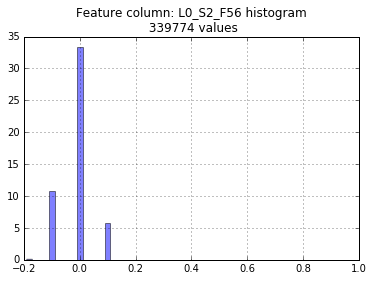

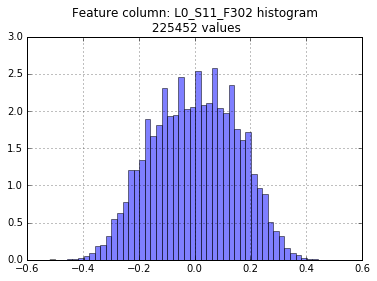

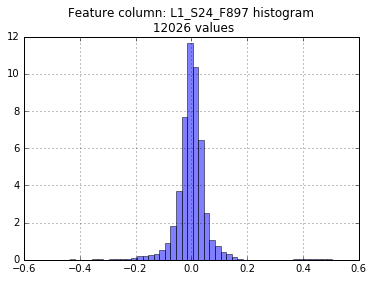

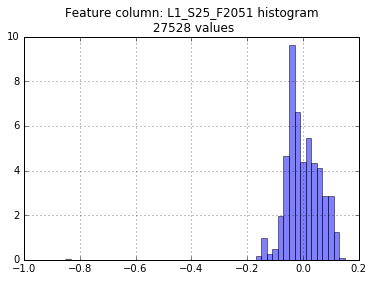

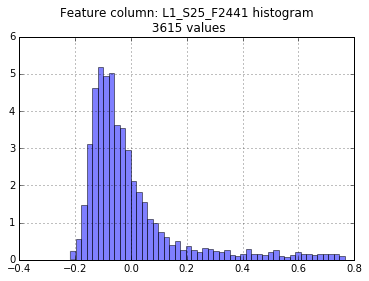

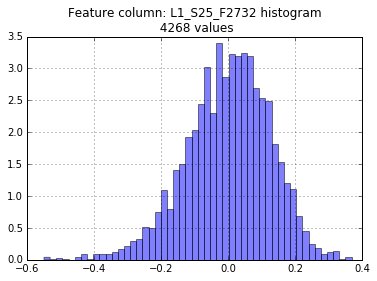

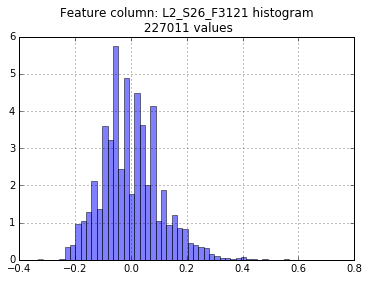

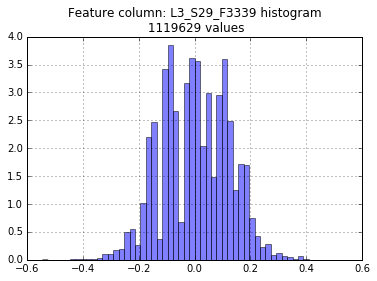

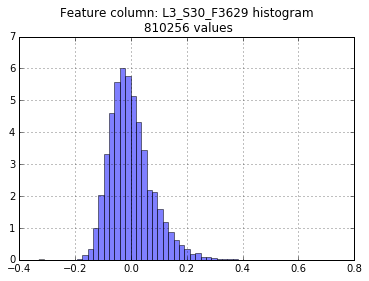

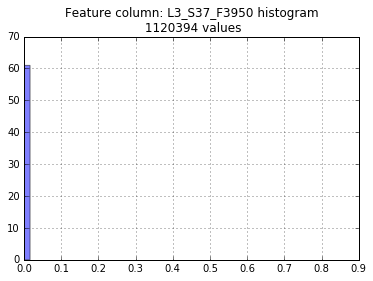

In [147]:
for feature in random_picks[::10]:
    df_num.iloc[:, feature].hist(bins=50, alpha=0.5, normed=True)
    plt.title('Feature column: %s histogram' % df_num.columns[feature] + '\n %d values' % len(df_num.iloc[:, feature].dropna()))
    plt.show()

How many positive targets do we have? i.e. 'Response' == 1

In [138]:
print('Response == 1 for {:.4f}% of the samples ({:.0f} cases)'.format(df_num.Response.sum() / len(df_num),
                                                               df_num.Response.sum()))

Response == 1 for 0.0058% of the samples (6864 cases)


Are the anolomies easy to detect as outliers in the distributions? Let's mark the positive responses on our histograms. The marking will be done by overlaying (normed) histrograms of the positive response histogram for each feature.

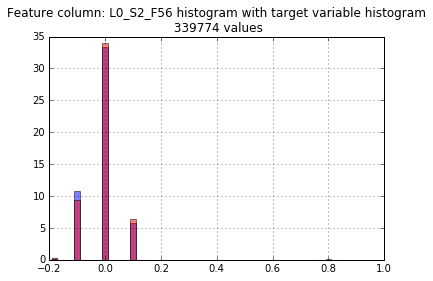

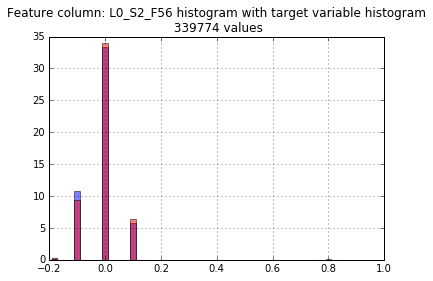

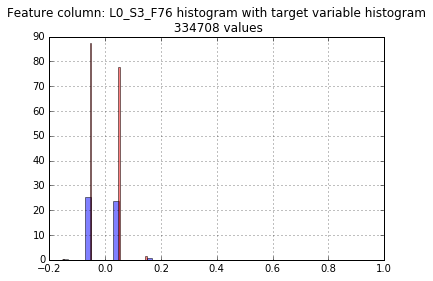

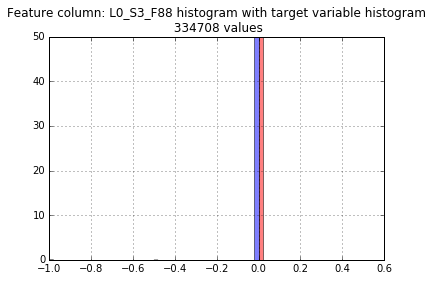

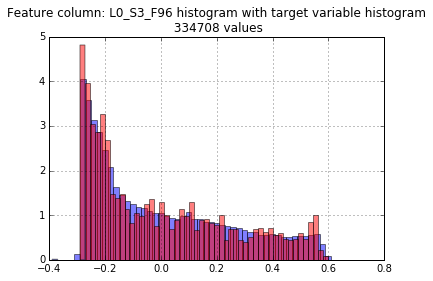

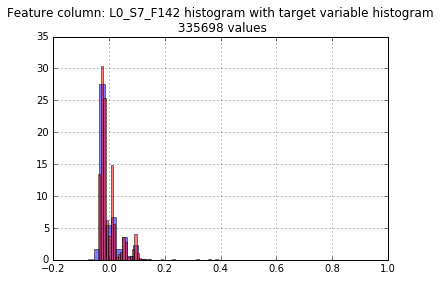

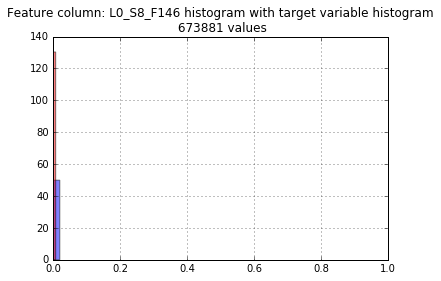

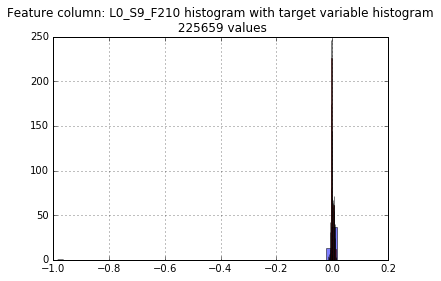

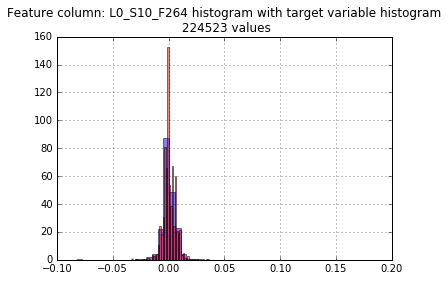

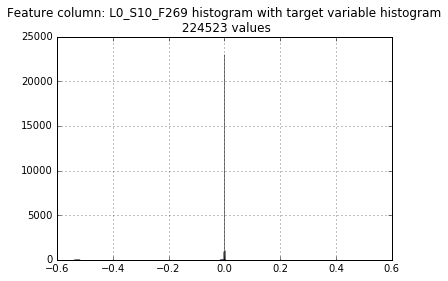

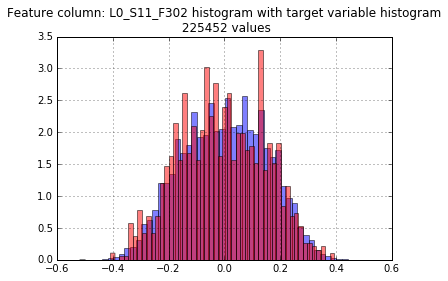

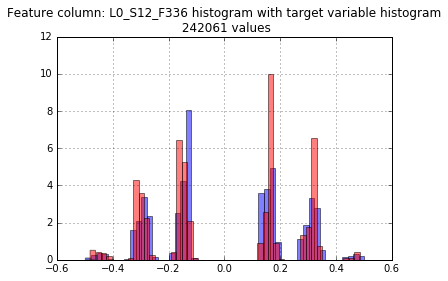

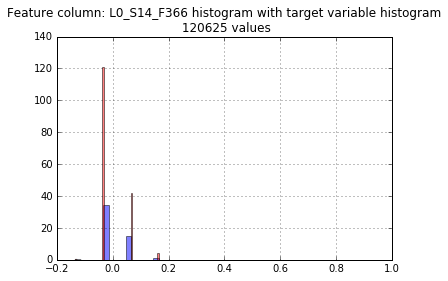

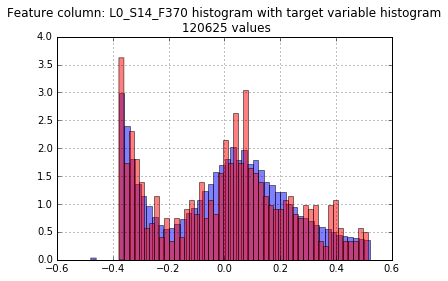

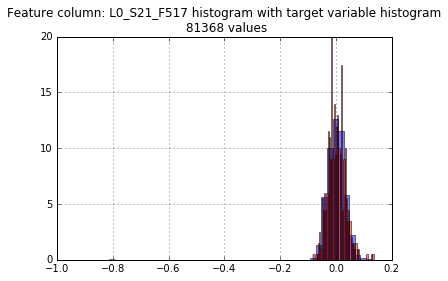

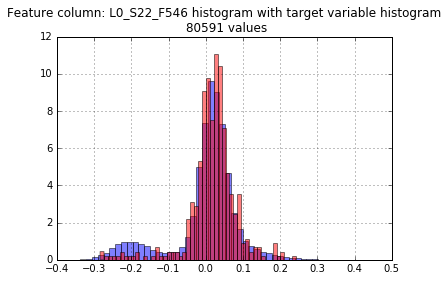

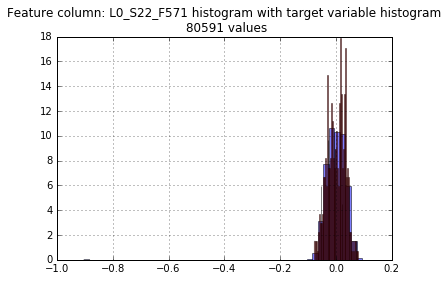

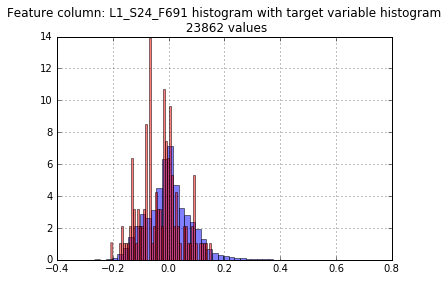

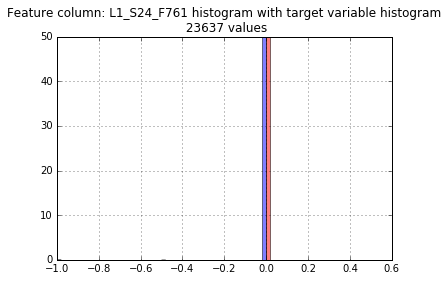

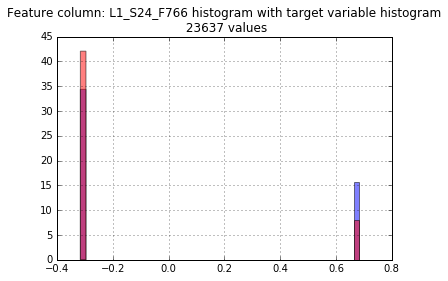

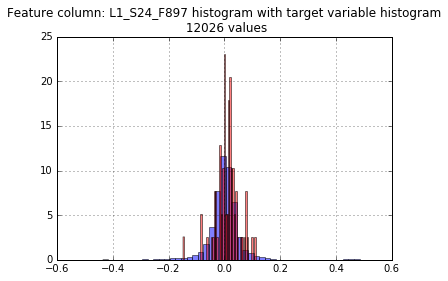

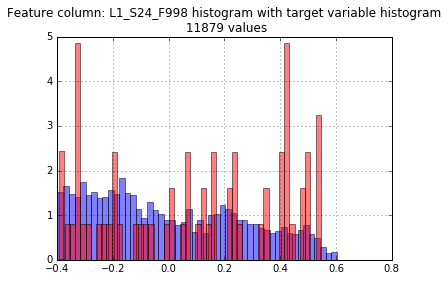

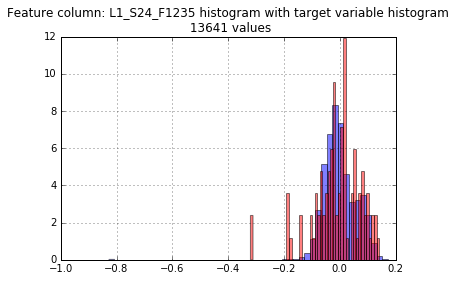

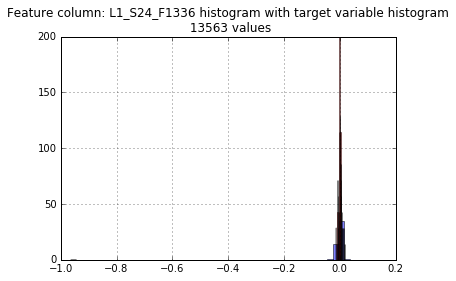

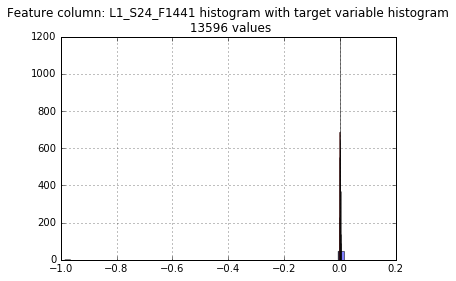

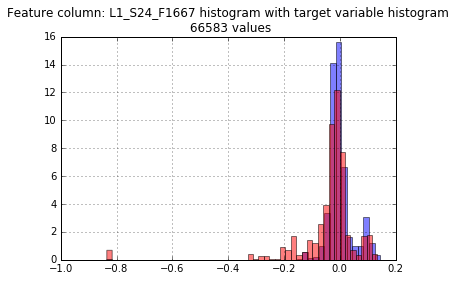

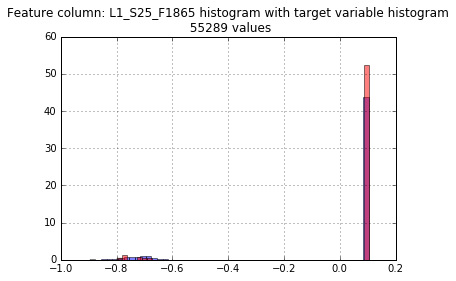

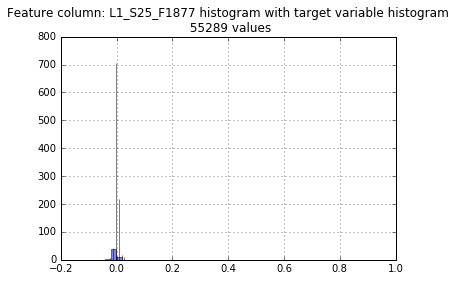

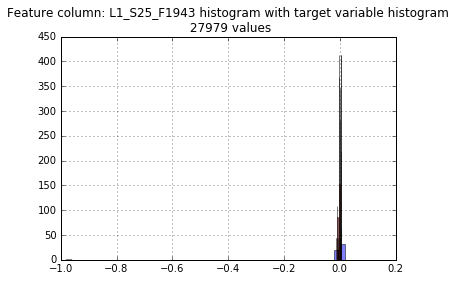

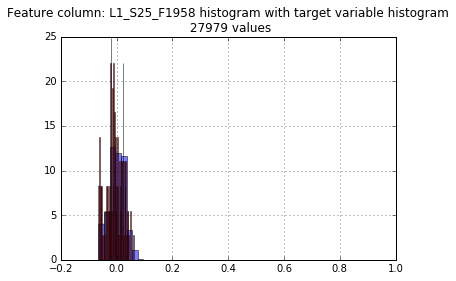

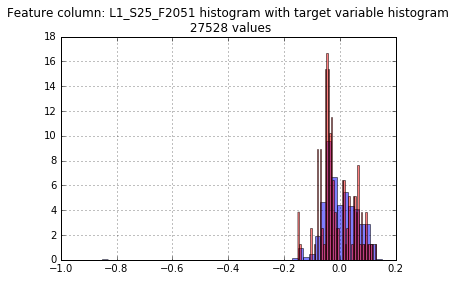

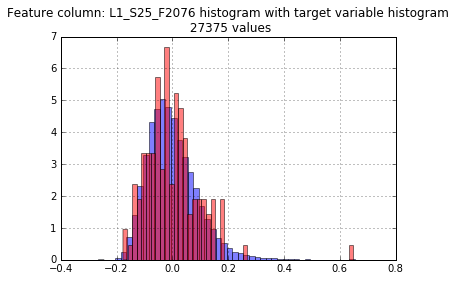

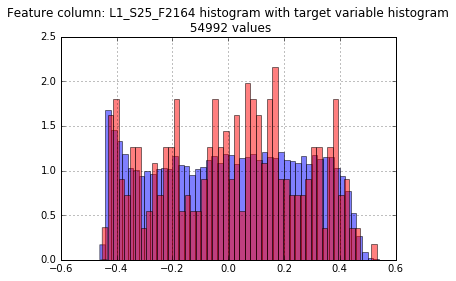

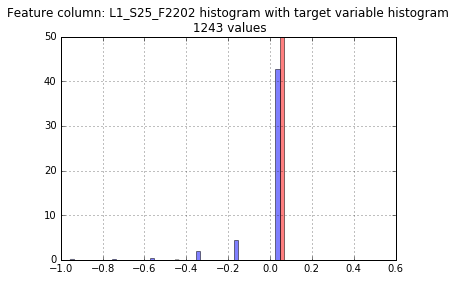

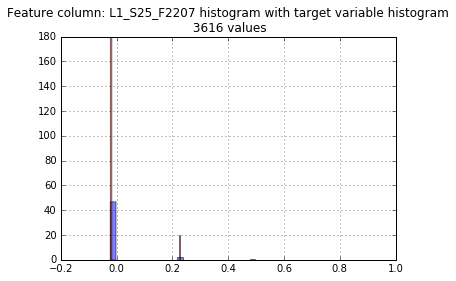

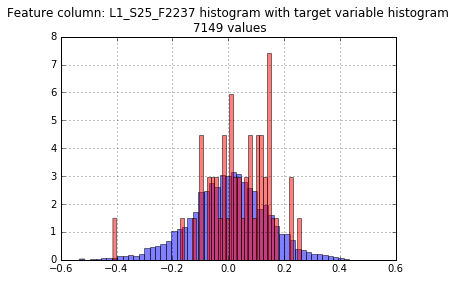

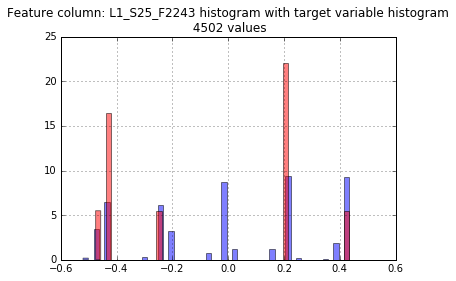

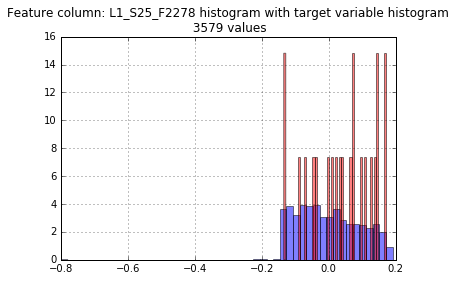

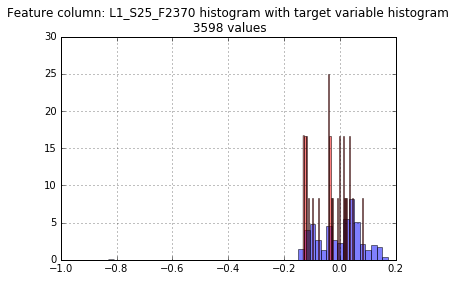

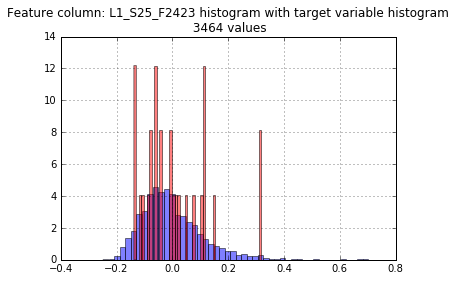

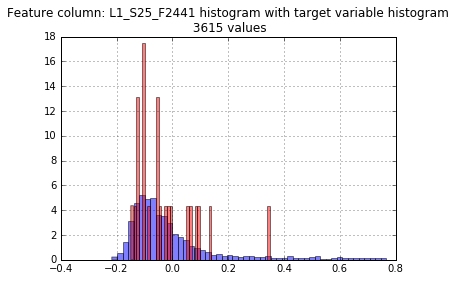

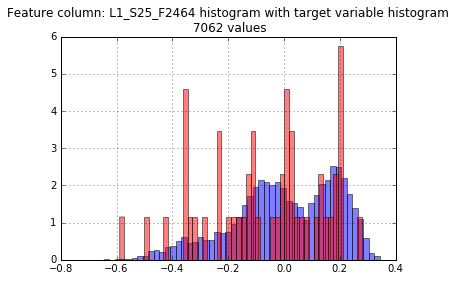

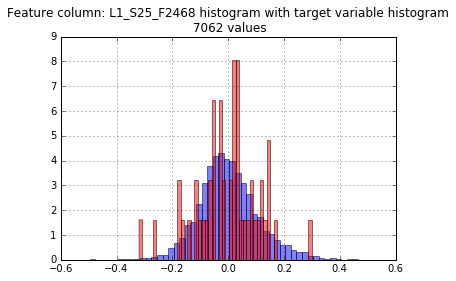

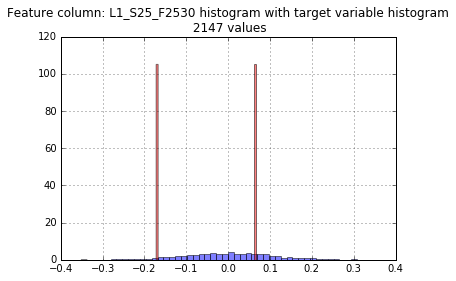

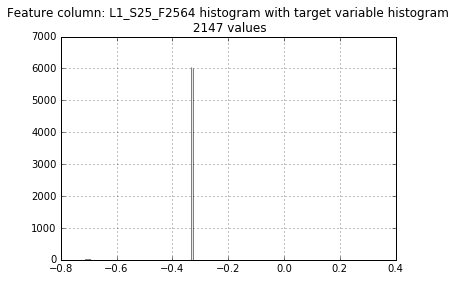

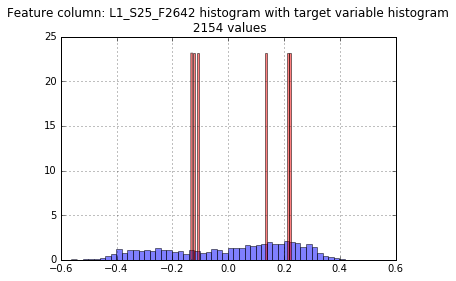

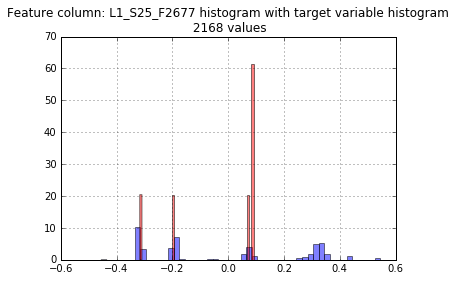

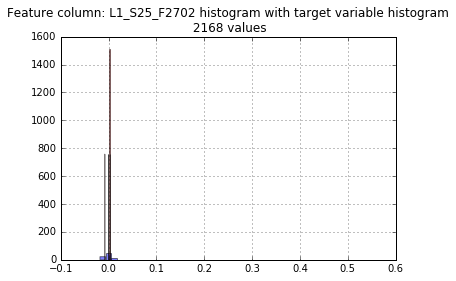

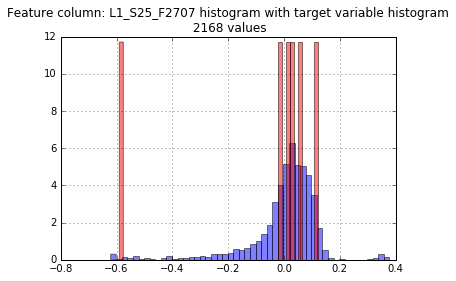

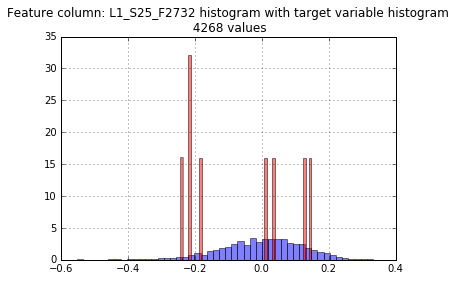

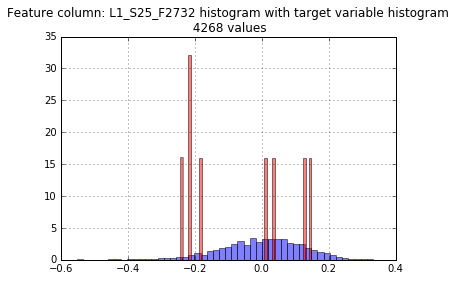

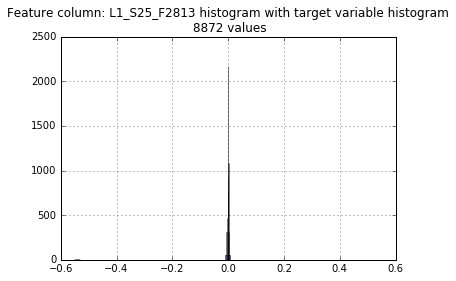

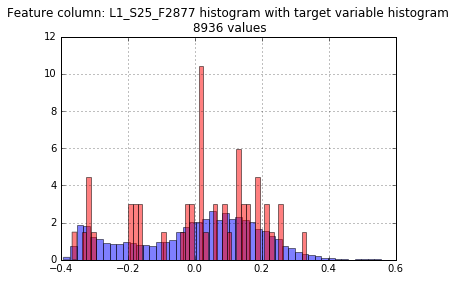

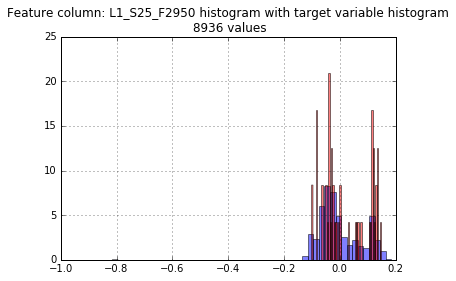

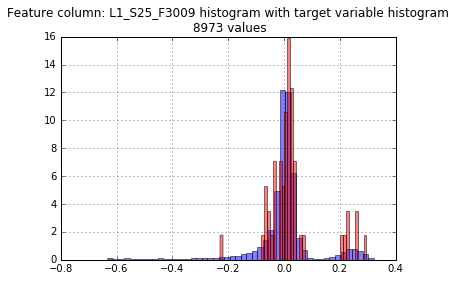

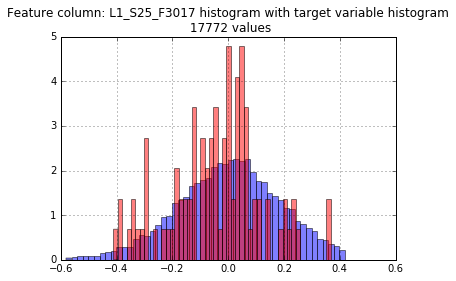

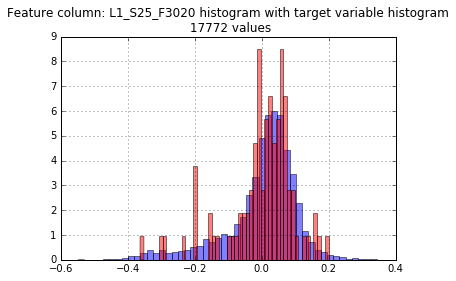

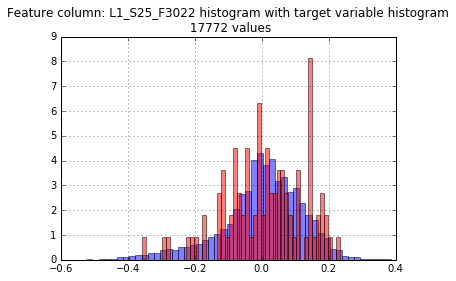

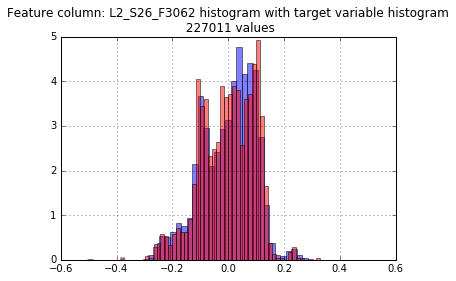

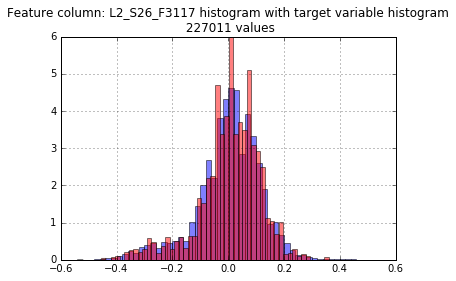

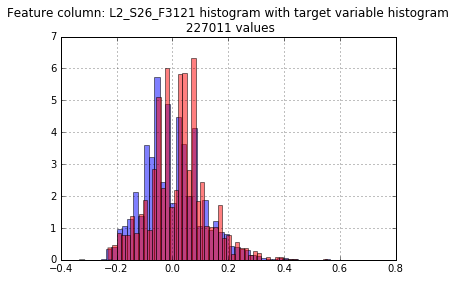

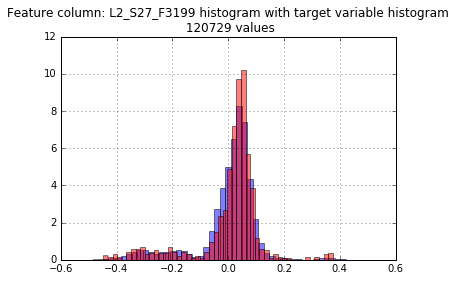

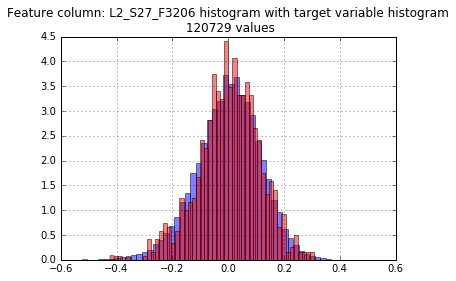

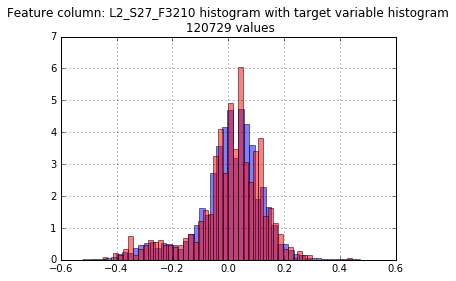

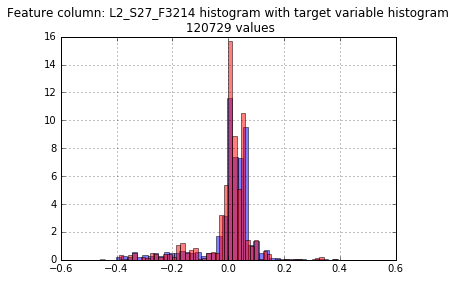

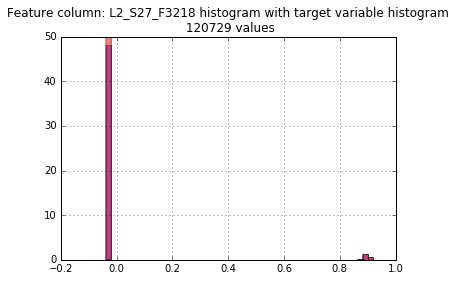

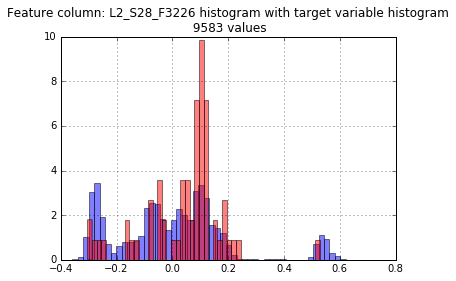

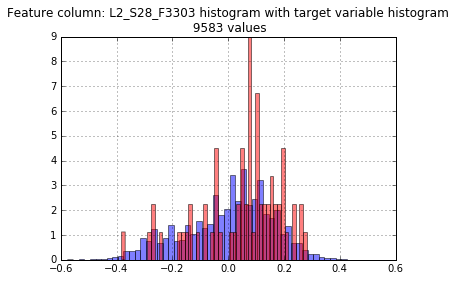

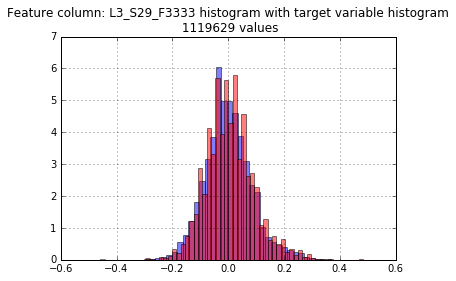

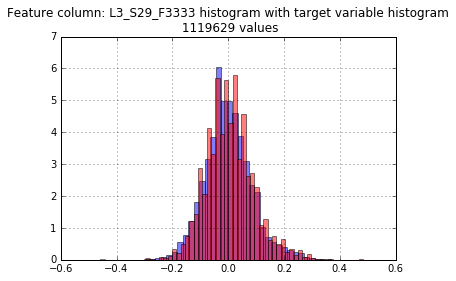

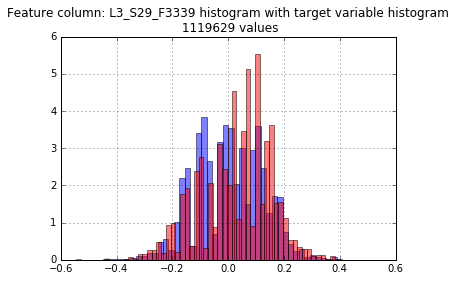

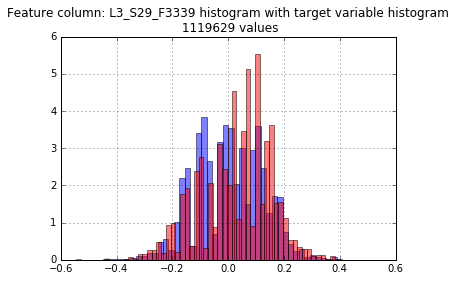

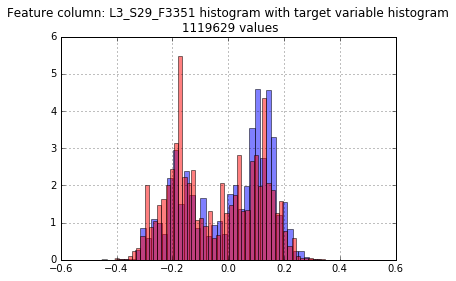

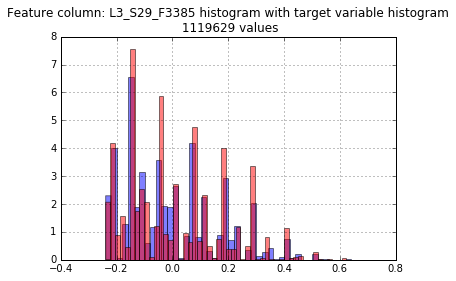

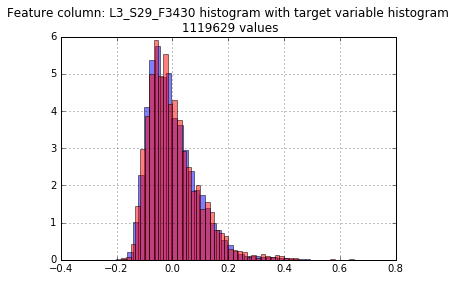

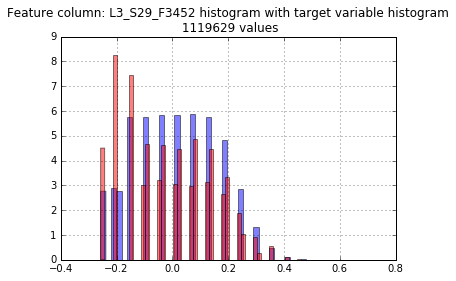

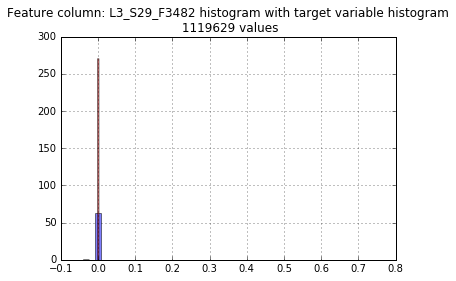

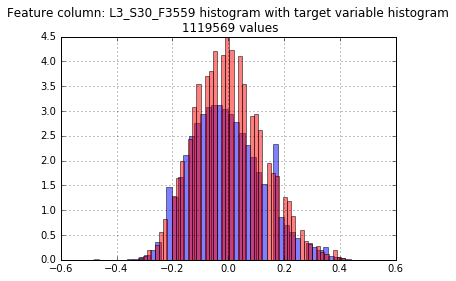

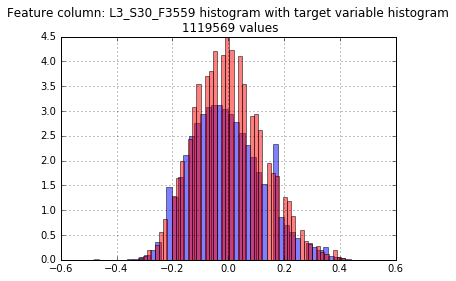

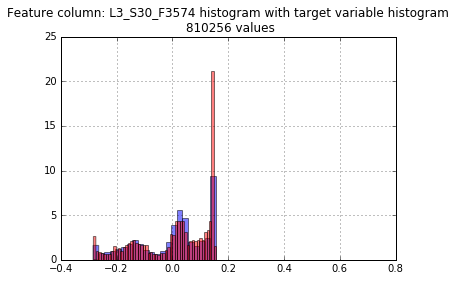

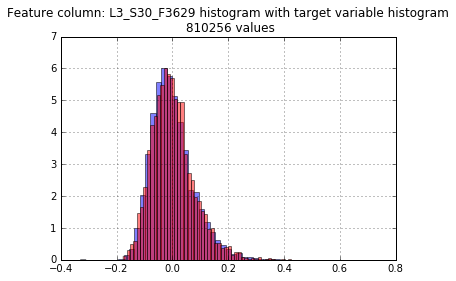

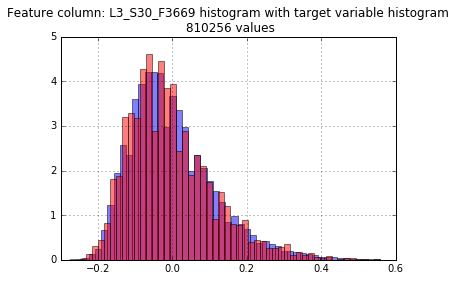

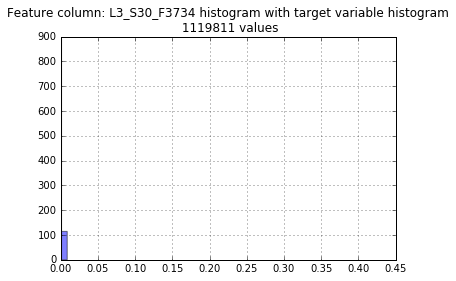

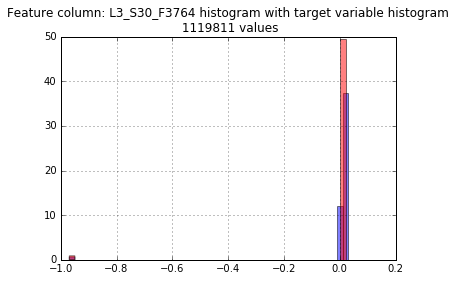

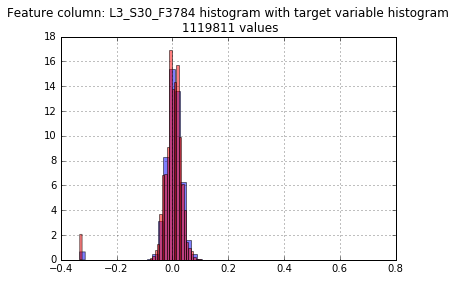

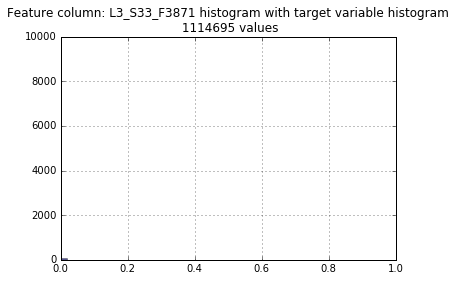

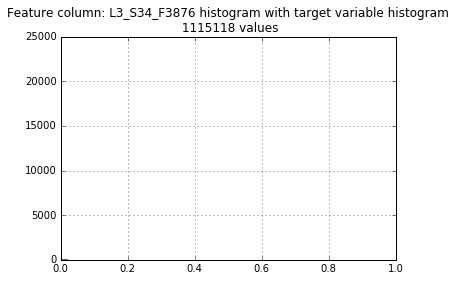

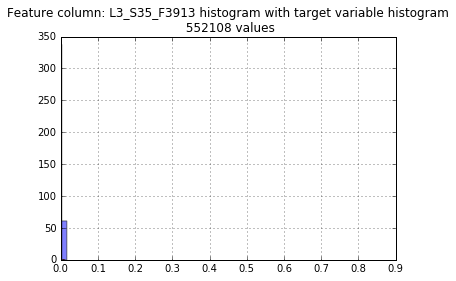

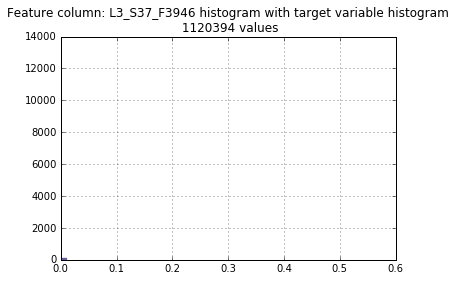

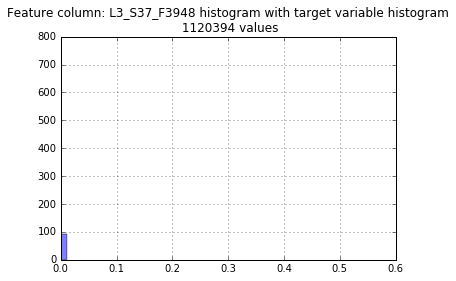

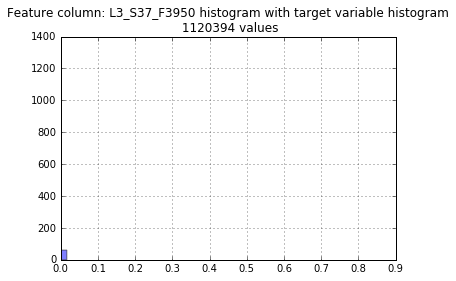

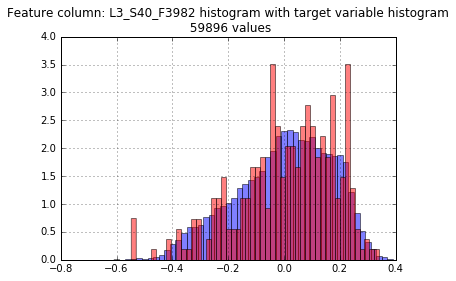

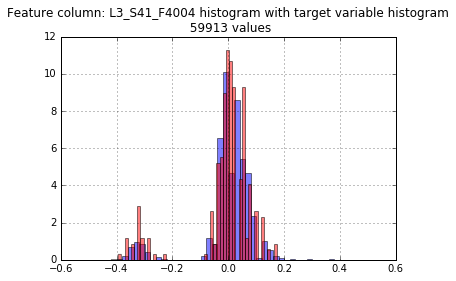

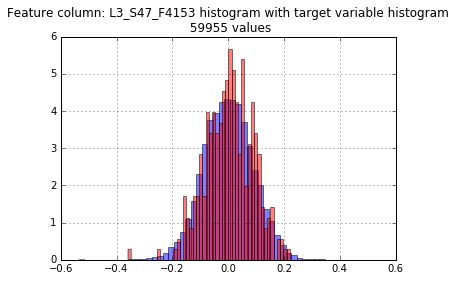

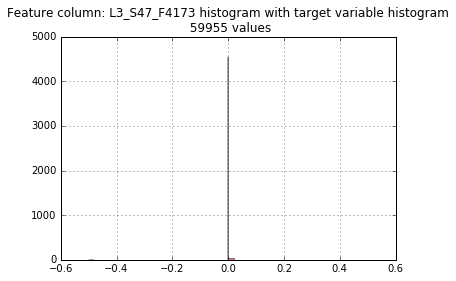

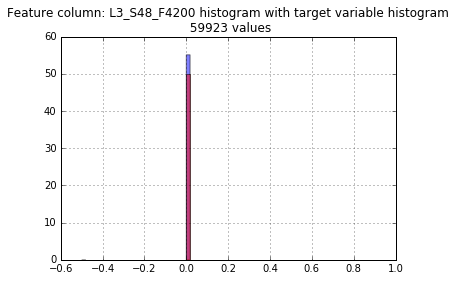

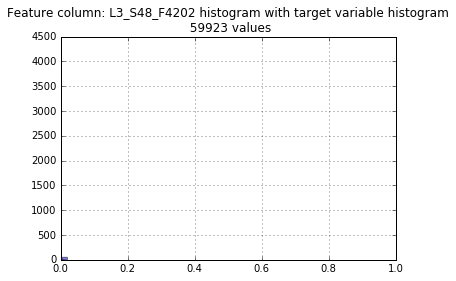

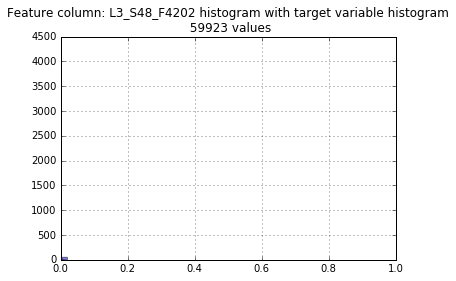

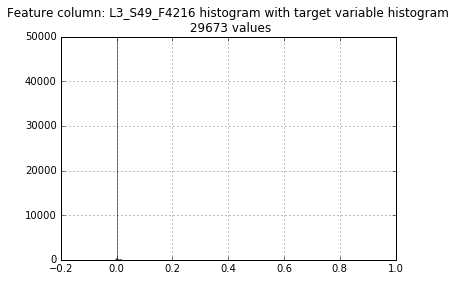

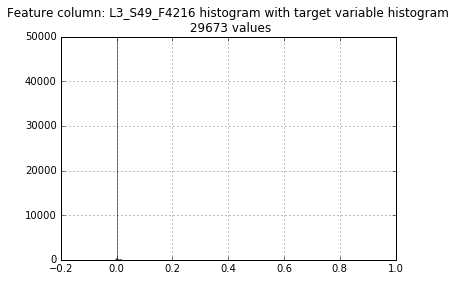

In [149]:
for feature in random_picks:
    df_num.iloc[:, feature].hist(bins=50, alpha=0.5, normed=True)
    df_num.iloc[:, feature][(df_num.Response == 1)].hist(bins=50, alpha=0.5, color='r', normed=True)
    plt.title('Feature column: %s histogram with target variable histogram' % df_num.columns[feature] + '\n %d values' % len(df_num.iloc[:, feature].dropna()))
    plt.show()

In [159]:
feat_mean = df_num.apply(lambda x: np.mean(x), axis=0).astype(np.float16).values
feat_std = df_num.apply(lambda x: np.std(x), axis=0).astype(np.float16).values

In [162]:
feat_mean = feat_mean[1:-1]
feat_std = feat_std[1:-1]

In [166]:
feat_std.mean()

0.1004

In [164]:
feat_mean.mean()

-8.0168e-05

It looks like they are all basically centered at 0 so we can __assume each normal to be centered at zero__.

In [156]:
# dict_means = df_num.apply(lambda x: np.mean(x), axis=0).astype(np.float16).to_dict()
# del dict_means['Id']
# del dict_means['Response']
# dict_means

{'L0_S0_F0': 5.5194e-05,
 'L0_S0_F10': 0.00016868,
 'L0_S0_F12': -4.3571e-05,
 'L0_S0_F14': -0.00035715,
 'L0_S0_F16': -7.7486e-07,
 'L0_S0_F18': 6.6161e-06,
 'L0_S0_F2': 8.9943e-05,
 'L0_S0_F20': 0.00028658,
 'L0_S0_F22': 0.00028825,
 'L0_S0_F4': 4.6372e-05,
 'L0_S0_F6': 2.2233e-05,
 'L0_S0_F8': -0.0001241,
 'L0_S10_F219': -3.1471e-05,
 'L0_S10_F224': 6.3419e-05,
 'L0_S10_F229': -1.8239e-05,
 'L0_S10_F234': -5.5432e-06,
 'L0_S10_F239': -7.8976e-05,
 'L0_S10_F244': -2.6703e-05,
 'L0_S10_F249': -1.4365e-05,
 'L0_S10_F254': -1.3292e-05,
 'L0_S10_F259': -0.00014269,
 'L0_S10_F264': -5.2452e-06,
 'L0_S10_F269': -2.6047e-05,
 'L0_S10_F274': 8.3447e-07,
 'L0_S11_F282': -3.2663e-05,
 'L0_S11_F286': -8.1182e-05,
 'L0_S11_F290': -3.3081e-05,
 'L0_S11_F294': -7.4506e-05,
 'L0_S11_F298': -0.00022721,
 'L0_S11_F302': -9.2447e-05,
 'L0_S11_F306': -3.0398e-05,
 'L0_S11_F310': -0.00015831,
 'L0_S11_F314': 0.00011301,
 'L0_S11_F318': 4.2021e-05,
 'L0_S11_F322': -0.00021911,
 'L0_S11_F326': -8.0943e-05

In [184]:
%%time
threshold = 3
N_outliers = pd.concat( (df_num.iloc[:, i+1].apply(lambda x: abs(x) > threshold*feat_std[i])
                         for i in range(df_num.shape[1]-2)), axis=1 ).sum(axis=1)

Wall time: 47min 37s


In [192]:
y_train = df_num.iloc[:, -1].values

Plot outliers for entire distribution (blue) and comparing with the distribution of positive responses (red).

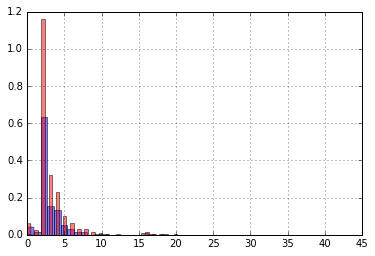

In [195]:
N_outliers.hist(bins=50, alpha=0.5, normed=True)
N_outliers[y_train == 1].hist(bins=50, alpha=0.5, color='r', normed=True)
plt.show()

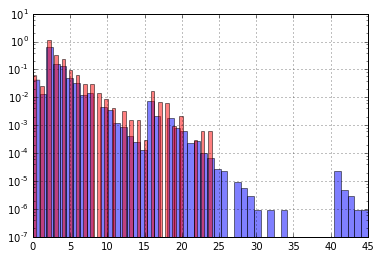

In [196]:
N_outliers.hist(bins=50, alpha=0.5, normed=True, log=True)
N_outliers[y_train == 1].hist(bins=50, alpha=0.5, color='r', normed=True, log=True)
plt.show()

Define scoring metric and attempt to use this feature to predict outcome.

In [185]:
def score_prediction(y_true, y_pred):
    ''' Evaluate the Matthews correlation coefficient (MCC) between
        the predicted and observed response. TP = true positive,
        TN = true negative, FP = false positive, FN = false negative '''
    
    TP = (y_true & y_pred).sum()
    TN = (1 - (y_true & y_pred)).sum()
    FP = (y_pred[y_true == 0]).sum()
    FN = (1 - y_pred[y_true == 1]).sum()
    
    val = (TP * TN) - (FP * FN)
    val = val / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    return val